**Image classification - custom model**

In [1]:
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd
import numpy as np

from keras.datasets import cifar10
from keras.models import Model
from keras.models import Sequential
from keras.layers import MaxPooling2D, Conv2D, Dropout, Dense, Flatten, Concatenate, BatchNormalization, Lambda, Activation
import keras
from keras import backend as K
from keras.optimizers import SGD,RMSprop, Adam, Adadelta
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers import Input

from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from random import randint
from IPython.display import SVG
import matplotlib.gridspec as gridspec

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
(trainX, trainy), (testX, testy) = cifar10.load_data()


170500096/170498071 [==============================] - 2s 0us/step


In [3]:
trainX = np.asarray(trainX)/255
testX = np.asarray(testX)/255


In [4]:
trainX, valX, trainy, valy = train_test_split(trainX, trainy, random_state=0, test_size=0.1, stratify=trainy)


In [5]:
trainy = keras.utils.to_categorical(trainy, 10)
valy = keras.utils.to_categorical(valy, 10)
testy = keras.utils.to_categorical(testy, 10)

In [6]:
dict = {0:'0', 1:'1', 2:'2', 3:'3', 4:'4', 5:'5', 6:'6', 7:'7', 8:'8', 9:'9'}
def showOrigDec(orig, dec, num=2):  ## function used for visualizing original and reconstructed images of the autoencoder model
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[300*i].reshape(til,til, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(dec[300*i].reshape(til,til, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [7]:
def show_test(m, d):  ## function used for visualizing the predicted and true labels of test data
    plt.figure(figsize =(40,8))
    for i in range(5):
        ax = plt.subplot(1, 5, i+1)
        test_image = np.expand_dims(d[101*i+5], axis=0)
        test_result = m.predict(test_image)
        plt.imshow(testX[101*i+5])
        index = np.argsort(test_result[0,:])
        plt.title("Pred:{}, True:{}".format(dict[index[1]], dict[testy[101*i+5][1]]))
    plt.show()

In [8]:
def report(predictions): ## function used for creating a classification report and confusion matrix
    cm=confusion_matrix(testy.argmax(axis=1), predictions.argmax(axis=1))
    print("Classification Report:\n")
    cr=classification_report(testy.argmax(axis=1),
                                predictions.argmax(axis=1), 
                                target_names=list(dict.values()))
    print(cr)
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=True, xticklabels = list(dict.values()), yticklabels = list(dict.values()), fmt="d",annot_kws={"size": 20})
    

In [9]:
def categorical_focal_loss(gamma=2., alpha=.25):
    """
    Softmax version of focal loss.
           m
      FL = ∑  -alpha * (1 - p_o,c)^gamma * y_o,c * log(p_o,c)
          c=1
      where m = number of classes, c = class and o = observation
    Parameters:
      alpha -- the same as weighing factor in balanced cross entropy
      gamma -- focusing parameter for modulating factor (1-p)
    Default value:
      gamma -- 2.0 as mentioned in the paper
      alpha -- 0.25 as mentioned in the paper
    References:
        Official paper: https://arxiv.org/pdf/1708.02002.pdf
        https://www.tensorflow.org/api_docs/python/tf/keras/backend/categorical_crossentropy
    Usage:
     model.compile(loss=[categorical_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """

        # Scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=1, keepdims=True)

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Sum the losses in mini_batch
        return K.sum(loss, axis=1)

    return categorical_focal_loss_fixed

In [10]:
def run_conv_model(data_aug):
    er = EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True)
    lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, min_delta=0.0001)
    callbacks = [er, lr]
    
    if not data_aug:
        history = model.fit(trainX, trainy, batch_size=batch_size,
                                 epochs=epochs,
                                 verbose=1, callbacks=callbacks,
                                 validation_data=(valX,valy))
#                                class_weight=class_weights)
    else:
        train_datagen = ImageDataGenerator(shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
        train_set_ae = train_datagen.flow(trainX, trainy, batch_size=batch_size)

        validation_datagen = ImageDataGenerator()
        validation_set_ae = validation_datagen.flow(valX, valy, batch_size=batch_size)
        
        history = model.fit_generator(train_set_ae,
                                           epochs=epochs,
                                           steps_per_epoch=np.ceil(trainX.shape[0]/batch_size),
                                           verbose=1, callbacks=callbacks,
                                           validation_data=(validation_set_ae),
                                           validation_steps=np.ceil(valX.shape[0]/batch_size))
#                                            class_weight=class_weights)
        
        return history

In [11]:
epochs = 10
batch_size = 100
size = trainX.shape[1]

In [12]:
def model_conv():
    '''
    Architektura modelu'''
    
    inputs = Input((size, size, 3))

    c1 = Conv2D(4, (3, 3),  padding = 'same')(inputs)
    c1 = BatchNormalization()(c1) 
    c1 = Activation('relu')(c1)
    c1 = Conv2D(4, (3, 3),  padding = 'same')(c1)
    c1 = BatchNormalization()(c1) 
    c1 = Activation('relu')(c1)

    c1 = MaxPooling2D(2, 2)(c1)

    c2 = Conv2D(16, (3, 3),  padding = 'same')(c1)
    c2 = BatchNormalization()(c2) 
    c2 = Activation('relu')(c2)
    c2 = Conv2D(16, (3, 3),  padding = 'same')(c2)
    c2 = BatchNormalization()(c2) 
    c2 = Activation('relu')(c2)

    c2 = MaxPooling2D(2, 2)(c2)


    c3 = Conv2D(32, (3, 3),  padding = 'same')(c2)
    c3 = BatchNormalization()(c3) 
    c3 = Activation('relu')(c3)
    c3 = Conv2D(32, (3, 3),  padding = 'same')(c3)
    c3 = BatchNormalization()(c3) 
    c3 = Activation('relu')(c3)

    c3 = MaxPooling2D(2, 2)(c3)

    c4 = Conv2D(64, (3, 3),  padding = 'same')(c3)
    c4 = BatchNormalization()(c4) 
    c4 = Activation('relu')(c4)
    c4 = Conv2D(64, (3, 3),  padding = 'same')(c4)
    c4 = BatchNormalization()(c4) 
    c4 = Activation('relu')(c4)

    c4 = MaxPooling2D(2, 2)(c4)

    c5 = Conv2D(128, (3, 3),  padding = 'same')(c4)
    c5 = BatchNormalization()(c5) 
    c5 = Activation('relu')(c5)
    c5 = Conv2D(128, (3, 3),  padding = 'same')(c5)
    c5 = BatchNormalization()(c5) 
    c5 = Activation('relu')(c5)

    c5 = MaxPooling2D(2, 2)(c5)


    f1 = Flatten()(c5)
    d1 = Dense(64, activation = 'relu')(f1)
    d3 = Dropout(0.2)(d1)
    #d3 = Dense(128, activation = 'relu')(d3)
    #d3 = Dropout(0.2)(d3)
    output = Dense(10, activation = 'softmax')(d3)


    model = Model(inputs = [inputs], outputs = [output])

    model.summary()
    return model


In [13]:
model=model_conv()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 4)         112       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 4)         16        
_________________________________________________________________
activation (Activation)      (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 4)         148       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 4)         16        
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 4)        

In [17]:
opt_rms = Adadelta()

'''model.compile(loss=[categorical_focal_loss(alpha=.05, gamma=2)],
                   optimizer=opt_rms,
                   metrics=['accuracy'])'''

model.compile(loss=keras.losses.CategoricalCrossentropy(),
                   optimizer=opt_rms,
                   metrics=['accuracy'])

In [18]:
history=run_conv_model(1)

Epoch 1/10
450/450 [==============================] - 135s 299ms/step - loss: 3.0289 - accuracy: 0.0986 - val_loss: 2.5365 - val_accuracy: 0.1052
Epoch 2/10
450/450 [==============================] - 136s 302ms/step - loss: 2.7566 - accuracy: 0.1102 - val_loss: 2.6636 - val_accuracy: 0.1208
Epoch 3/10
450/450 [==============================] - 132s 294ms/step - loss: 2.5877 - accuracy: 0.1209 - val_loss: 2.5156 - val_accuracy: 0.1362
Epoch 4/10
450/450 [==============================] - 133s 295ms/step - loss: 2.4734 - accuracy: 0.1353 - val_loss: 2.4060 - val_accuracy: 0.1508
Epoch 5/10
450/450 [==============================] - 133s 295ms/step - loss: 2.3978 - accuracy: 0.1478 - val_loss: 2.3279 - val_accuracy: 0.1704
Epoch 6/10
450/450 [==============================] - 136s 302ms/step - loss: 2.3441 - accuracy: 0.1634 - val_loss: 2.2691 - val_accuracy: 0.1834
Epoch 7/10
450/450 [==============================] - 133s 296ms/step - loss: 2.3095 - accuracy: 0.1683 - val_loss: 2.2286 -

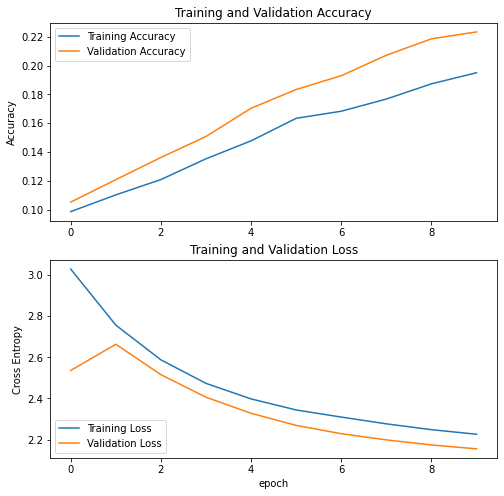

In [19]:
#Accuracy and loss chats
acc =history.history['accuracy']
val_acc =history.history['val_accuracy']
loss =history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

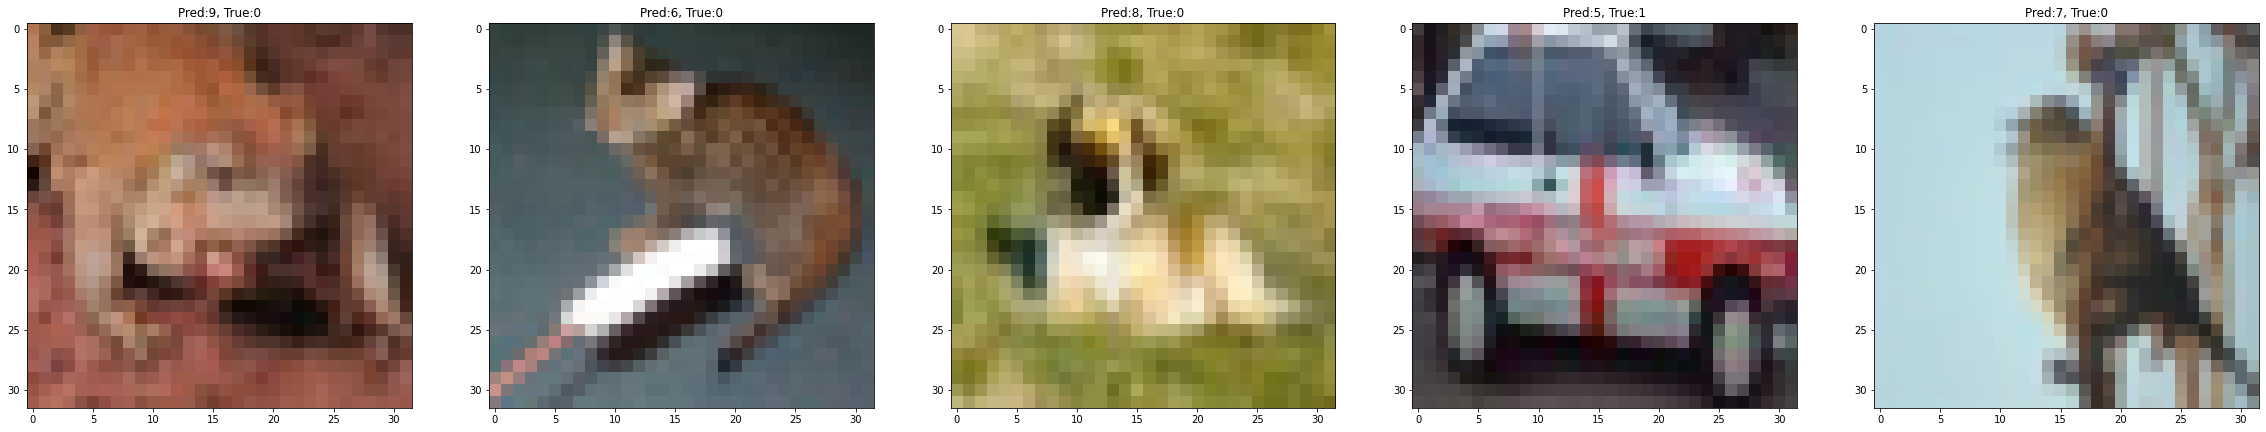

In [20]:
#check sample of classifications
show_test(model, testX)

Classification Report:

              precision    recall  f1-score   support

           0       0.26      0.27      0.26      1000
           1       0.18      0.31      0.23      1000
           2       0.22      0.07      0.10      1000
           3       0.16      0.17      0.16      1000
           4       0.25      0.18      0.21      1000
           5       0.21      0.24      0.23      1000
           6       0.21      0.17      0.19      1000
           7       0.18      0.17      0.18      1000
           8       0.35      0.35      0.35      1000
           9       0.23      0.28      0.26      1000

    accuracy                           0.22     10000
   macro avg       0.23      0.22      0.22     10000
weighted avg       0.23      0.22      0.22     10000



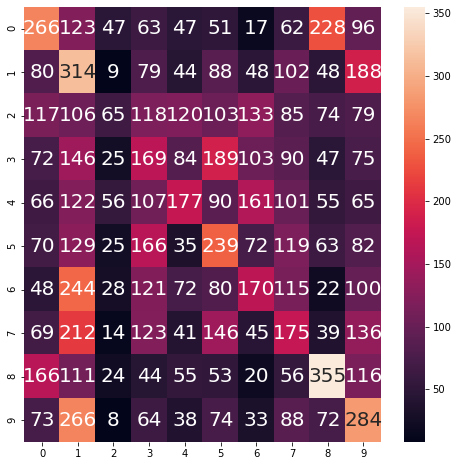

In [21]:
#Predict test data
predictions = model.predict(testX)
#Classification summary
report(predictions)

In [22]:
# Save the weights
model.save_weights('model_weights.h5')

# Save the model architecture
with open('model_architecture.json', 'w') as f:
    f.write(model.to_json())

In [24]:

#load model
from keras.models import model_from_json

# Model reconstruction from JSON file
with open('model_architecture.json', 'r') as f:
    model = model_from_json(f.read())

# Load weights into the new model
model.load_weights('model_weights.h5')